<a href="https://colab.research.google.com/github/BRIAN12682/Automation-Projects/blob/main/Brain_Tumour_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install torchmetrics
!pip install torchmetrics[image]
!pip install torch-fidelity
!pip install scipy
!pip install pytorch-fid
!pip install torch-summary
!pip install matplotlib==3.5
!pip install captum==0.5

In [5]:
import os, sys, itertools, glob, torch, torchvision, random, shutil, uuid, io
import numpy as np
from numpy import asarray
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import ArtistAnimation
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms, models
import torchvision.utils as vutils
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split, ConcatDataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

torch.manual_seed(46)
device = "cuda" if torch.cuda.is_available() else "cpu"

from pytorch_fid.fid_score import calculate_fid_given_paths
from torchmetrics.image.fid import FrechetInceptionDistance
fid_sc = FrechetInceptionDistance(normalize=True).to(device)
from torchmetrics.image.inception import InceptionScore
inception_sc = InceptionScore(normalize=True).to(device)

import PIL.Image
from PIL import ImageFile
import IPython.display
from IPython.display import HTML

from captum.attr import visualization as viz
from captum.attr import GuidedGradCam, NoiseTunnel
from matplotlib import cm

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 152MB/s]
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# import zipfile
# import os

# # Specify the path to the zip file on Google Drive
# zip_file_path = '/content/drive/MyDrive/train'


# extraction_path = '/content/dataset/'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extraction_path)


In [10]:
print('Classes: ', os.listdir("/content/drive/MyDrive/train"))

Classes:  ['yes', 'no']


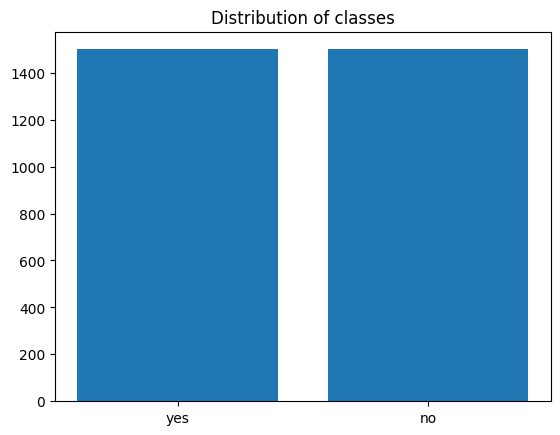

In [13]:
classes = os.listdir("/content/drive/MyDrive/train")
sum_images = []
for i in range(2):
    img_base_path = "/content/drive/MyDrive/train/" + str(classes[i])
    images = os.listdir(img_base_path)
    sum_images.append(len(images))
plt.bar(classes, sum_images)
plt.title('Distribution of classes')
plt.show()

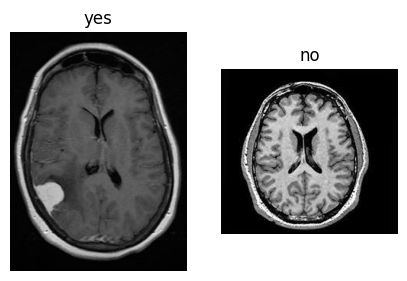

In [14]:
images = []
paths = []

fig,ax = plt.subplots(1,2,figsize = (5,5))
ax = ax.ravel()

for i in range(2):
    img_base_path = "/content/drive/MyDrive/train/" + str(classes[i])
    timages = os.listdir(img_base_path)
    images_path_to_display = os.path.join(img_base_path, str(timages[0]))
    paths.append(images_path_to_display)
    img = Image.open(images_path_to_display)
    images.append(img)
    image = images[i]
    ax[i].imshow(image)
    ax[i].set_title(classes[i])
    ax[i].axis('off')

plt.show()

In [15]:
data = datasets.ImageFolder('/content/drive/MyDrive/train')
generator = torch.Generator().manual_seed(46)
train, validation = random_split(data, [0.8, 0.2], generator = generator)
print(len(train))
print(len(validation))

2400
600


In [16]:
class loadData(Dataset):
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])

        y = self.dataset[index][1]
        return x, y

    def __len__(self):
        return len(self.dataset)

In [17]:
train_transform = transforms.Compose([transforms.Resize((64, 64)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

no_transform = transforms.Compose([transforms.Resize((64, 64)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   transforms.ToPILImage()])

In [18]:
trainset = loadData(train, train_transform)
valset = loadData(validation, no_transform)

In [19]:
try:
  os.makedirs('/content/drive/MyDrive/validation')
except:
  pass

for idx in range(len(valset)):
  img, label = valset.__getitem__(idx)
  img.save(f"/content/drive/MyDrive/validation/{idx}.png")

In [20]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, drop_last=True)
examples = next(iter(trainloader))
for label, img  in enumerate(examples):
    print(img.shape)

torch.Size([16, 3, 64, 64])
torch.Size([16])


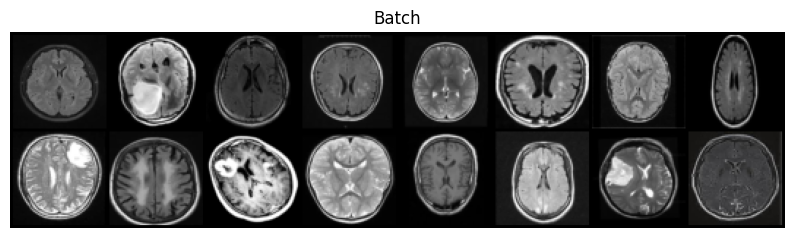

In [21]:
real_batch = next(iter(trainloader))
plt.figure(figsize=(10, 15))
plt.axis("off")
plt.title("Batch")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:16], padding=2, normalize=True),(1,2,0)))
plt.show()

In [22]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise + embed_size, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
      embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
      x = torch.cat([x, embedding], dim=1)
      return self.net(x)

In [23]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img+1, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )
        self.embed = nn.Embedding(num_classes, img_size * img_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
      embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
      x = torch.cat([x, embedding], dim=1)
      return self.disc(x)

In [24]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [25]:
# Hyperparameters etc.
img_size = 64
channels_img = 3
num_classes = 2
gen_embedding = 128
z_dim = 128
num_epochs = 200
lambda_gp = 10
features_d = 64
features_g = 64
critic_iter = 3

In [30]:
#channels_noise, channels_img, features_g, num_classes, img_size, embed_size
gen = Generator(z_dim, channels_img, features_g, num_classes, img_size, gen_embedding).to(device)
#channels_img, features_d, num_classes, img_size
critic = Discriminator(channels_img, features_d, num_classes, img_size).to(device)
initialize_weights(gen) #initialize with 0 mean and 0.02 std
initialize_weights(critic) #initialize with 0 mean and 0.02 std

In [32]:
# summary(gen, input_shape = (224, 224, 3))
# summary(critic)

In [33]:
def gradient_penalty(critic, labels, real, fake, device="cpu"):
    batch_size, C, H, W = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1)).repeat(1, C, H, W).to(device)

    # Compute interpolated images
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [34]:
lossG = nn.MSELoss() #Generator loss MSE according to LSGAN
opt_gen = optim.Adam(gen.parameters(), lr=0.0002, betas = (0.5, 0.99)) #Generator optimizer: Adam with lr = 2e-4, b1 = 0.5, b2 = 0.99
opt_critic = optim.Adam(critic.parameters(), lr=0.0001, betas=(0.0, 0.9)) #Discriminator optimizer: Adam with lr = 1e-4, b1 = 0, b2 = 0.9

In [ ]:
gen.train()
critic.train()

losses_critic = [] #Store Discriminator loss
losses_gen = [] #Store Generator loss
fid_scores = [] #Store FID Score
fake_imgs = [] #Store the fake grid throw epochs

for epoch in range(num_epochs): #iterate throw 500 epochs
    for batch_idx, (real, labels) in enumerate(trainloader): #iterate throw each batch every epoch
        real = real.to(device) #real images to GPU
        cur_batch_size = real.shape[0] #save the batch size
        labels = labels.to(device) #labels to GPU

        # Train Critic: WGAN-GP Critic loss + Gradient Penalty
        #minimizing the difference between real and fake
        #according to the critic loss and gradient penalty
        for _ in range(critic_iter): #train discriminator 3 times more than generator
          noise = torch.randn(cur_batch_size, z_dim, 1, 1).to(device) #make noise of shape [N (batch) * 128 * 1 * 1] and move to GPU
          fake = gen(noise, labels) #generate fake images passing noise and labels to generator
          critic_real = critic(real, labels).reshape(-1) #generate response from discriminatr regarding real
          critic_fake = critic(fake, labels).reshape(-1) #generate response from discriminator regarding fake
          gp = gradient_penalty(critic, labels, real, fake, device=device) #apply gradient penalty
          loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp *gp) #compute critic loss with gradient penalty regularization
          losses_critic.append(loss_critic.item()) #save and backpropagate
          critic.zero_grad()
          loss_critic.backward(retain_graph=True)
          opt_critic.step()

        # Train Generator: LSGAN (Backpropagation of MSE throw generator allows to reach higher quality images)
        # minimize the MSE
        real_target = torch.full((cur_batch_size,), 1., device=device) #Generate real label tensor
        gen.zero_grad()
        output = critic(fake, labels).reshape(-1) #generate response regarding fake
        errG = lossG(output, real_target) #compute MSE between fake and real
        errG.backward() #Backpropagate the error throw the generator
        D_G_z2 = output.mean().item()
        opt_gen.step()
        losses_gen.append(D_G_z2)

    #Eval
    try:
      os.makedirs('tmp')
    except:
      pass

    with torch.no_grad():
      #create grid of synthetic images
      fake = gen(noise, labels)
      img_grid_fake = torchvision.utils.make_grid(fake.cpu(), normalize=True)
      vutils.save_image(img_grid_fake, '/content/drive/MyDrive/fake_samples_epoch_%03d.png' % (epoch))
      fake_imgs.append(img_grid_fake)

      #create batches of synthetic images
      noise_val = torch.randn(600, z_dim, 1, 1, device=device)
      labels_val = torch.randint(0, num_classes, (600,), device=device)
      fake_imgs_val = gen(noise_val, labels_val)

    #save synthetic images on tmp
    for idx in range(fake_imgs_val.shape[0]):
      fake_img_val = fake_imgs_val[idx]
      vutils.save_image(fake_img_val, f"tmp/{str(uuid.uuid4())}.png",normalize=True)

    #fid (synthetic vs validation)
    fid = calculate_fid_given_paths(['/content/drive/MyDrive/validation','tmp'], dims=2048, device = device, batch_size=16)
    fid_scores.append(fid)
    shutil.rmtree('tmp')

    #print loss
    print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(trainloader)} Critic Loss: {loss_critic.item():.4f}, Generator Loss: {D_G_z2:.4f}, FID: {fid:.4f}")


    #save to retrain
    state1 = {
        'epoch': epoch,
        'state_dict': gen.state_dict(),
        'optimizer': opt_gen.state_dict(),
        'loss': D_G_z2}
    torch.save(state1, '/content/drive/MyDrive/generator.pth')

    state2 = {
        'epoch': epoch,
        'state_dict': critic.state_dict(),
        'optimizer': opt_critic.state_dict(),
        'loss': loss_critic}
    torch.save(state2, '/content/drive/MyDrive/critic.pth')